In [1]:
from __future__ import division
import time
from scipy.special import logsumexp  #to deal with potential overflow issues
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import csv

from scipy.misc import imresize # to reduce size of images

%matplotlib inline

class_names = ['tshirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)        
    writer.writerow(['id', 'label'])
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        
def read_fMNIST(dataset = "training", path = "./",dim=16):
    """
    reading in the "Fashion MNIST" data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    Dimension: dim specifies the target image dimension (default is to reduce images to 16x16)
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    
    X = reduceImg(X,dim)
    
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X
         
            
def showImage(image,ax=None):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    if len(image.shape) > 1:
        n=image.shape[0]
    else:
        n=int(np.sqrt(image.shape[0]))
        image = image[-n**2:]
        image = image.reshape(n,n)

    
    if ax==None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    

def reduceImg(X,dnew):
    # image size in X is hardcoded = 28 (not best practice!)
    xNew=np.zeros((X.shape[0],dnew*dnew))
    for i in range(X.shape[0]):
        xNew[i]=imresize(X[i].reshape(28,28),(dnew,dnew),'bicubic').flatten()
    return xNew

In [2]:
# Load training data
xTrain, yTrain = read_fMNIST('training')
# Load validation data
xVal, yVal = read_fMNIST('validation')

# scale pixel values to [0,1] to make things better-behaved numerically
xTrain=xTrain/255
xVal=xVal/255

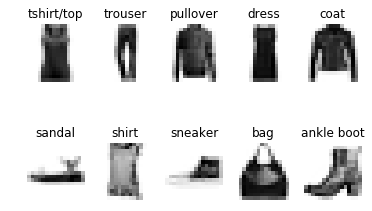

In [3]:
for c in range(10):
    ax=plt.subplot(2,5,c+1)
    ax.clear()
    idx = np.argmax(np.argmax(yTrain,axis=1)==c)
    showImage(xTrain[idx],ax)
    ax.set_title(class_names[c])
    


In [4]:
class GaussianMixtureModel(object):
    """Gaussian Mixture Model"""
    
    def __init__(self, X, num_comp, max_iter=50, eps=10**(-7), cov_type='diag'):
        """Initialize the GMM model.
        num_feat: Feature dimension of our data
        num_comp: Number of components to fit in the mixture model.
        max_iter: Maximum number of EM iterations.
        cov_type: Type of covariance matrix used by multivariate Gaussian models ('diag': diagonal, otherwise full)
        """
        self.nf = X.shape[1]
        self.nc = num_comp
        self.max_iter = max_iter
        self.eps = 0.00001
        self.cov_type = cov_type
        
        # Initialization: feel free to improve this.
        # Note that we are passing the data X so you can use it to try smarter init strategies
        
        # initialize mixing prob to be uniform
        self.pi = np.repeat(1.0/self.nc, self.nc)
        # initialize means to random (Gaussian) vectors

        self.mu=np.random.uniform(0,1,((self.nc,self.nf)))  #np.zeros((self.nc,self.nf)) 
        self.sigma=np.zeros((self.nc,self.nf,self.nf))
        # initialize covariances to I_nf (identity)
        for c in range(self.nc):
            self.sigma[c]=np.eye(self.nf)
    
        
    def Estep(self, X):
        """Update the soft weights and calculate likelihood in the process."""
        log_gamma = np.zeros((X.shape[0], self.nc))
        log_pi = np.log(self.pi)
        for comp in range(self.nc): # calculate weighted density for each component
            
            # put here code you need to compute log_gamma as explained below; everything else will follow
            sh = X - self.mu[comp]
            rp = sh.dot(np.linalg.inv(self.sigma[comp]))
            exp_power = np.sum(sh * rp, axis=1)
            log_gamma[:, comp] = log_pi[comp] - 0.5*(exp_power + np.linalg.slogdet(2*np.pi*self.sigma[comp])[1])
            
        # now you can use the values of log_gamma to calculate log-likelihood, responsibilities, etc
        log_prob_per_instance = logsumexp(log_gamma, axis=1, keepdims=True)
        log_likelihood = np.mean(log_prob_per_instance)
        gamma = np.exp(log_gamma - log_prob_per_instance)  # note that this will compute actual responsibilities
        return gamma, log_likelihood, log_prob_per_instance
        
        
    def Mstep(self, X, gamma):
        """Update the model params given the soft weights."""
        # Calculate unnormalized pi with epsilon added to avoid cases where a component gets no instances
        unnorm_pi = np.sum(gamma, axis=0) + self.eps # shape = (nc,);
        # Update the overall soft assignments to different components
        self.pi = unnorm_pi/np.sum(unnorm_pi)
        
        for comp in range(self.nc): # update parameters for each component
            # Scale the different instances by the soft weight for the current component
            resp_data = np.dot(np.diag(gamma[:, comp]), X)
            # Normalize the responsible data by total soft weight to get mean
            self.mu[comp] = np.sum(resp_data, axis=0)/unnorm_pi[comp]
            
            shift_data = X - self.mu[comp]   # x - mu
            # Captures the multiplication of gamma in covariance calculation
            resp_scaled_shift_data = np.dot(np.diag(gamma[:, comp]), shift_data)
            
            if self.cov_type == 'diag':
                
                self.sigma[comp] = np.sum(resp_scaled_shift_data * shift_data, axis=0)
                self.sigma[comp] = self.sigma[comp]/unnorm_pi[comp] + np.eye(self.nf)*self.eps
                
            else:

                self.sigma[comp] = resp_scaled_shift_data.transpose().dot(shift_data)
                self.sigma[comp] = self.sigma[comp]/unnorm_pi[comp] + np.eye(self.nf)*self.eps
                
    
    def train(self, X,verbose='final'):
        """Train the model using EM."""
        prev_likelihood = -np.inf  # Keep track of previous log likelihood
        gamma, log_likelihood, _ = self.Estep(X)  
        for i in range(self.max_iter):
            self.Mstep(X, gamma)  # M-step
            gamma, log_likelihood, _ = self.Estep(X)  
            if np.isclose(log_likelihood,prev_likelihood):
                break
            else:
                prev_likelihood = log_likelihood
            if verbose == 'iter':
                print ("   Iteration: %d, log-likelihood: %.4f" %(i, log_likelihood))
            
        if verbose == 'final':
                print ("Iteration %d (final), log-likelihood: %.4f" %(i, log_likelihood))
                
                
    def trainFast(self,X,verbose='final',rs=[.03,.1,.3,1]):
        """
        Train the model using EM, gradually fitting larger portion of the data
        rs specifies the fractions of the full data set size to use
        Note: by making the last elements of rs less than 1 you can effectively train on a subset of data
        (examples past the first r*X.shape[0] won't be seen at all)
        """
        for r in rs:
            self.train(X[0:int(np.floor(X.shape[0]*r))],verbose='final')
        

In [5]:
# organize data by class
classData=dict()
for y in range(10):
    classData[y]=xTrain[np.argmax(yTrain,axis=1)==y]


In [6]:
def get_accuracy(models, X,y):
    """
    Compute accuracy of the GMM generative model on (X,y).
    model[c] is the GMM for class c
    Returns (acc, yhat) where yhat are the predictions (in label form)
    """
    total_data = 0.0
    correct = 0.0
    C = len(models)
    N = X.shape[0]
    logLik = np.zeros((N,C))
    for c in range(C):
        _,_, ll_class = models[c].Estep(X)
        logLik[:,c] = np.squeeze(ll_class)
    yhat = np.argmax(logLik,axis=1)
    acc = np.mean(yhat==np.argmax(y,axis=1))
    return acc, yhat




In [7]:
def showMeans(gmmModels,c,handles=False):
    """
    Display means for Gaussian components of gmmModels for class c
    """
    k = mmodels[c].nc
    fig,axes = plt.subplots(1,k)
    
    for j in range(k):
        if k==1:
            ax=axes
        else:
            ax=axes[j]
        showImage(gmmModels[c].mu[j],ax)
        ax.axis('off')
        if j==0:
            ax.set_title(class_names[c]+'/'+str(j))
        else:
            ax.set_title('/'+str(j))
    if handles:
        return fig,axes

Iteration 12 (final), log-likelihood: -211536.2201
Iteration 17 (final), log-likelihood: -221395.5114
Iteration 5 (final), log-likelihood: -216767.3532
================ class 0(tshirt/top), mixture of 3 diag Gaussians
Iteration 7 (final), log-likelihood: -141980.9839
Iteration 4 (final), log-likelihood: -141559.3250
Iteration 5 (final), log-likelihood: -143035.6820
================ class 1(trouser), mixture of 3 diag Gaussians
Iteration 25 (final), log-likelihood: -222559.1642
Iteration 4 (final), log-likelihood: -222304.3478
Iteration 6 (final), log-likelihood: -226399.9158
================ class 2(pullover), mixture of 3 diag Gaussians
Iteration 28 (final), log-likelihood: -186181.2055
Iteration 20 (final), log-likelihood: -194982.3442
Iteration 10 (final), log-likelihood: -191506.2867
================ class 3(dress), mixture of 3 diag Gaussians
Iteration 12 (final), log-likelihood: -210281.5435
Iteration 3 (final), log-likelihood: -211519.3769
Iteration 16 (final), log-likelihood: -

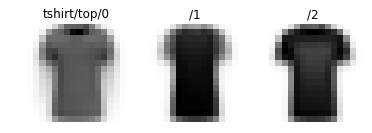

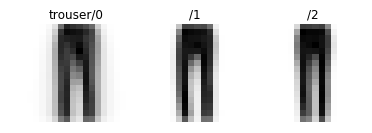

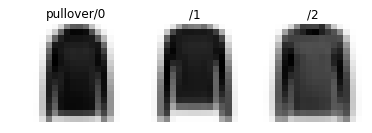

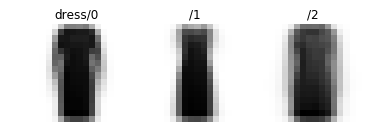

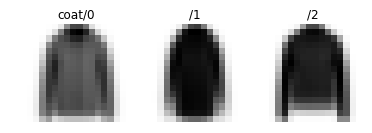

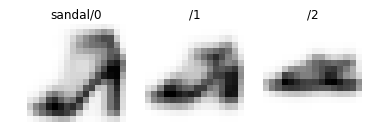

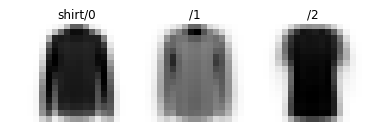

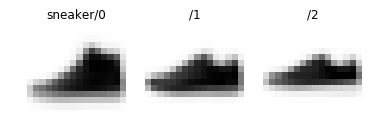

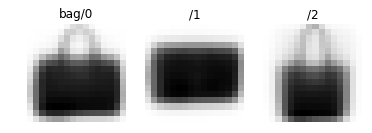

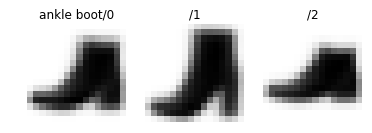

Iteration 10 (final), log-likelihood: -153380.0757
Iteration 18 (final), log-likelihood: -161530.1224
Iteration 31 (final), log-likelihood: -161169.6935
================ class 0(tshirt/top), mixture of 12 diag Gaussians
Iteration 26 (final), log-likelihood: -93662.2349
Iteration 16 (final), log-likelihood: -95267.6378
Iteration 14 (final), log-likelihood: -94807.3708
================ class 1(trouser), mixture of 12 diag Gaussians
Iteration 15 (final), log-likelihood: -158804.0651
Iteration 15 (final), log-likelihood: -162007.0997
Iteration 34 (final), log-likelihood: -167243.3684
================ class 2(pullover), mixture of 12 diag Gaussians
Iteration 22 (final), log-likelihood: -126131.5832
Iteration 39 (final), log-likelihood: -140236.1633
Iteration 37 (final), log-likelihood: -140588.8426
================ class 3(dress), mixture of 12 diag Gaussians
Iteration 13 (final), log-likelihood: -140815.4793
Iteration 16 (final), log-likelihood: -143813.6501
Iteration 16 (final), log-likel

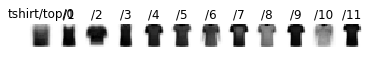

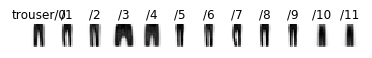

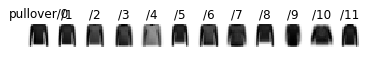

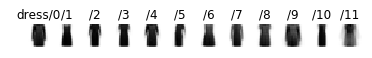

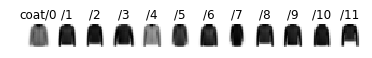

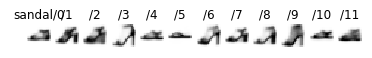

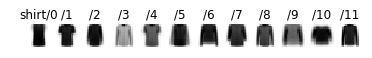

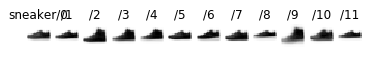

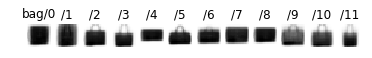

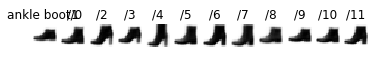

In [8]:
ks=[3,12]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=50, cov_type='diag')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.1,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d diag Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-diag (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

Iteration 3 (final), log-likelihood: 905.3359
Iteration 4 (final), log-likelihood: 581.4540
Iteration 3 (final), log-likelihood: 507.2026
================ class 0(tshirt/top), mixture of 3 full Gaussians
Iteration 3 (final), log-likelihood: 965.2858
Iteration 1 (final), log-likelihood: 827.5629
Iteration 2 (final), log-likelihood: 778.6072
================ class 1(trouser), mixture of 3 full Gaussians
Iteration 4 (final), log-likelihood: 913.2992
Iteration 4 (final), log-likelihood: 602.6394
Iteration 7 (final), log-likelihood: 531.6312
================ class 2(pullover), mixture of 3 full Gaussians
Iteration 3 (final), log-likelihood: 912.8949
Iteration 2 (final), log-likelihood: 672.6460
Iteration 29 (final), log-likelihood: 656.1196
================ class 3(dress), mixture of 3 full Gaussians
Iteration 3 (final), log-likelihood: 893.8401
Iteration 1 (final), log-likelihood: 602.3180
Iteration 1 (final), log-likelihood: 526.2318
================ class 4(coat), mixture of 3 full Gauss

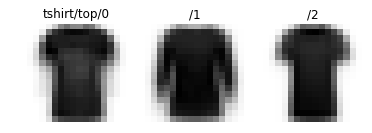

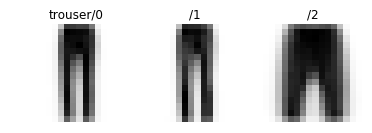

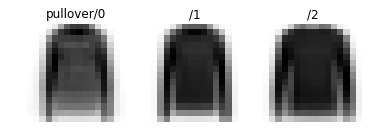

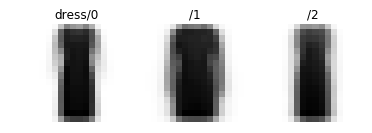

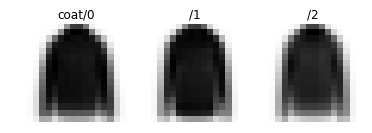

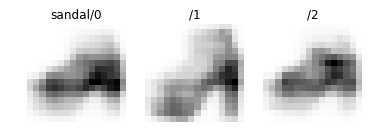

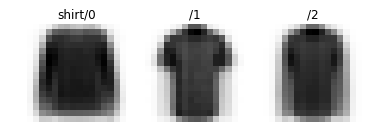

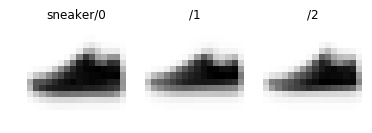

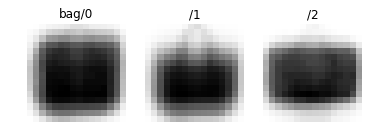

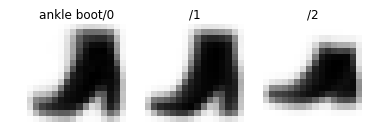

Iteration 5 (final), log-likelihood: 1100.4369
Iteration 17 (final), log-likelihood: 709.4556
Iteration 19 (final), log-likelihood: 593.2637
================ class 0(tshirt/top), mixture of 12 full Gaussians
Iteration 5 (final), log-likelihood: 1109.5829
Iteration 1 (final), log-likelihood: 887.0948
Iteration 2 (final), log-likelihood: 792.1538
================ class 1(trouser), mixture of 12 full Gaussians
Iteration 4 (final), log-likelihood: 1077.7005
Iteration 2 (final), log-likelihood: 633.5830
Iteration 21 (final), log-likelihood: 578.6482
================ class 2(pullover), mixture of 12 full Gaussians
Iteration 3 (final), log-likelihood: 1107.1600
Iteration 6 (final), log-likelihood: 791.5462
Iteration 7 (final), log-likelihood: 683.6019
================ class 3(dress), mixture of 12 full Gaussians
Iteration 3 (final), log-likelihood: 1111.8195
Iteration 2 (final), log-likelihood: 752.9268
Iteration 29 (final), log-likelihood: 621.9948
================ class 4(coat), mixture of 

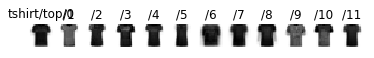

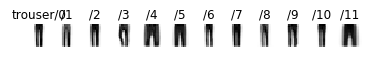

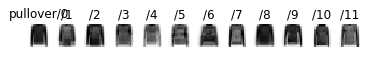

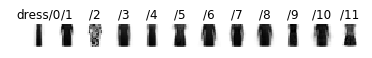

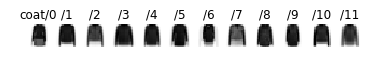

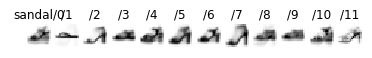

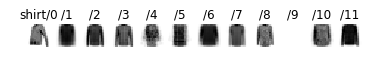

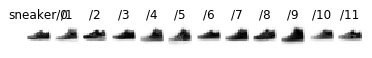

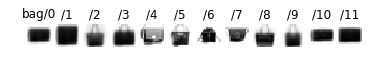

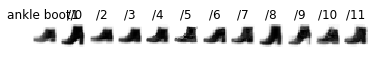

In [9]:
ks=[3,12]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=30, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))
    for y in range(10):
        showMeans(mmodels,y)
        plt.show()

Things to do:
- fill in the code to run the training above
- use the code to also run QDA and Naive Bayes experiments
- decide on any improvements/extensions, and try them out
- settle on the best overall generative model, and compute and save test prediction (below)

In [10]:
QDA

NameError: name 'QDA' is not defined

In [11]:
qdamodels = dict()

for y in range(10):
    qdamodels[y] = GaussianMixtureModel(classData[y], 1, max_iter=2, cov_type='full')
    qdamodels[y].trainFast(classData[y],verbose='final',rs=[1])


qdaacc, _ = get_accuracy(qdamodels,xVal,yVal)
qdaaccTrain, _ = get_accuracy(qdamodels,xTrain,yTrain)
print('QDA-full accuracy:  %.4f  [ %.4f on train]'%(qdaacc, qdaacc))

Iteration 1 (final), log-likelihood: 443.6280
Iteration 1 (final), log-likelihood: 703.9348
Iteration 1 (final), log-likelihood: 477.3404
Iteration 1 (final), log-likelihood: 539.9084
Iteration 1 (final), log-likelihood: 511.9470
Iteration 1 (final), log-likelihood: 427.4621
Iteration 1 (final), log-likelihood: 405.3595
Iteration 1 (final), log-likelihood: 680.7830
Iteration 1 (final), log-likelihood: 320.9016
Iteration 1 (final), log-likelihood: 483.5869
QDA-full accuracy:  0.6957  [ 0.6957 on train]


In [12]:
NB

NameError: name 'NB' is not defined

In [13]:
nbmodels = dict()

for y in range(10):
    nbmodels[y] = GaussianMixtureModel(classData[y], 1, max_iter=2, cov_type='diag')
    nbmodels[y].trainFast(classData[y], verbose='final', rs=[1])

nbacc, _ = get_accuracy(nbmodels, xVal, yVal)
nbaccTrain, _ = get_accuracy(nbmodels, xTrain, yTrain)
print('Naive Bayes accuracy: %.4f [ %.4f on train]' % (nbacc, nbaccTrain))

Iteration 1 (final), log-likelihood: -296878.6079
Iteration 1 (final), log-likelihood: -212870.0345
Iteration 1 (final), log-likelihood: -318494.6991
Iteration 1 (final), log-likelihood: -274357.9721
Iteration 1 (final), log-likelihood: -338797.6569
Iteration 1 (final), log-likelihood: -401983.5734
Iteration 1 (final), log-likelihood: -346832.3645
Iteration 1 (final), log-likelihood: -215199.5141
Iteration 1 (final), log-likelihood: -629369.2370
Iteration 1 (final), log-likelihood: -412577.5269
Naive Bayes accuracy: 0.6878 [ 0.6888 on train]


In [ ]:
Question 7

In [23]:
ks=[3,12]
gmmacc=dict()
gmmaccTrain=dict()

for k in ks:
    mmodels=dict()
    
    for y in range(10):
        mmodels[y] = GaussianMixtureModel(classData[y], k, max_iter=40, cov_type='full')
        mmodels[y].trainFast(classData[y],verbose='final',rs=[.05,.25,1])
        print('================ class '+str(y)+'('+class_names[y]+'), mixture of %d full Gaussians'%k)
        
    gmmacc[k], _ = get_accuracy(mmodels,xVal,yVal)
    gmmaccTrain[k], _ = get_accuracy(mmodels,xTrain,yTrain)
    print('GMM-full (%d) accuracy:  %.4f  [ %.4f on train]'%(k,gmmacc[k],gmmaccTrain[k]))

Iteration 3 (final), log-likelihood: 890.3716
Iteration 1 (final), log-likelihood: 569.3823
Iteration 1 (final), log-likelihood: 466.0113
================ class 0(tshirt/top), mixture of 3 full Gaussians
Iteration 4 (final), log-likelihood: 965.6501
Iteration 10 (final), log-likelihood: 833.7794
Iteration 12 (final), log-likelihood: 823.8095
================ class 1(trouser), mixture of 3 full Gaussians
Iteration 4 (final), log-likelihood: 901.0040
Iteration 5 (final), log-likelihood: 584.5983
Iteration 3 (final), log-likelihood: 519.3166
================ class 2(pullover), mixture of 3 full Gaussians
Iteration 3 (final), log-likelihood: 914.3585
Iteration 4 (final), log-likelihood: 687.2635
Iteration 12 (final), log-likelihood: 648.1168
================ class 3(dress), mixture of 3 full Gaussians
Iteration 3 (final), log-likelihood: 910.5910
Iteration 10 (final), log-likelihood: 605.1574
Iteration 27 (final), log-likelihood: 581.3443
================ class 4(coat), mixture of 3 full G

In [20]:
bestmodel = mmodels

In [21]:
def get_predictions(models, X):
    C = len(models)
    N = X.shape[0]
    logLik = np.zeros((N,C))
    for c in range(C):
        _,_, ll_class = models[c].Estep(X)
        logLik[:,c] = np.squeeze(ll_class)
    yhat = np.argmax(logLik,axis=1)
    return yhat

In [22]:
xTe = read_fMNIST('testing')
preds = get_predictions(bestmodel, xTe)
create_submission_file("kaggle-submission.csv", preds)

In [ ]:
Problem 7 explanation: For problem 7 I choose the Full Gaussian Mixture Model
and I tuned the max numbers of interations to 40. In the end the train accuracy was 0.7914 and 
the validation accuracy 0.7299. 